In [ ]:
#In this exercise we chose the first use case which is "Predict the stock market price for Tesla. 
"""
We decided to use Regression Algorithm since it`s suitable for predictions of continious values such us price, age, weather, traffic etc. 
based on earlier results or measurements. On the other hand the classification algorithm is more suitable to classify or distict values as 
True or False, White or Black, Real or Fake and so on. 
"""

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [84]:
def str_to_dt(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

In [95]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_dt(first_date_str)
    last_date  = str_to_dt(last_date_str)

    target_date = first_date
  
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
    
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
        if last_time:
            break
    
        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df


In [96]:
def win_df_to_date_X_y(win_df):
    df_as_np = win_df.to_numpy()
    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)


In [87]:
df = pd.read_csv("https://raw.githubusercontent.com/komandoyoko/DAVE3625---1/main/oblig2/TSLA.csv")

df = df[['Date', 'Close']]

df.head()

,Date,Close
0,2022-10-24,211.250000
1,2022-10-25,222.419998
2,2022-10-26,224.639999
3,2022-10-27,225.089996
4,2022-10-28,228.520004


In [88]:
df['Date'] = df['Date'].apply(str_to_dt)

df.index = df.pop('Date')

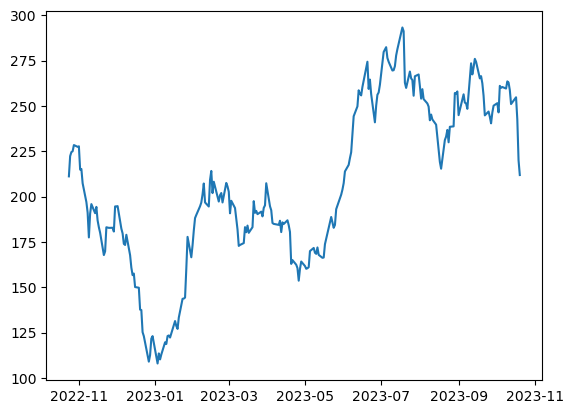

In [89]:
plt.plot(df.index, df['Close'])

In [90]:
df

,Close
Date,
2022-10-24,211.250000
2022-10-25,222.419998
2022-10-26,224.639999
2022-10-27,225.089996
2022-10-28,228.520004
...,...
2023-10-16,253.919998
2023-10-17,254.850006
2023-10-18,242.679993


In [91]:
df = df_to_win_df(df, "2022-10-27", "2023-10-20", n=3)

In [92]:
df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-10-27,211.250000,222.419998,224.639999,225.089996
1,2022-10-28,222.419998,224.639999,225.089996,228.520004
2,2022-10-31,224.639999,225.089996,228.520004,227.539993
3,2022-11-01,225.089996,228.520004,227.539993,227.820007
4,2022-11-02,228.520004,227.539993,227.820007,214.979996
...,...,...,...,...,...
242,2023-10-16,262.989990,258.869995,251.119995,253.919998
243,2023-10-17,258.869995,251.119995,253.919998,254.850006
244,2023-10-18,251.119995,253.919998,254.850006,242.679993
245,2023-10-19,253.919998,254.850006,242.679993,220.110001


In [99]:
dates, X, y = win_df_to_date_X_y(df)

dates.shape, X.shape, y.shape

((247,), (247, 3, 1), (247,))

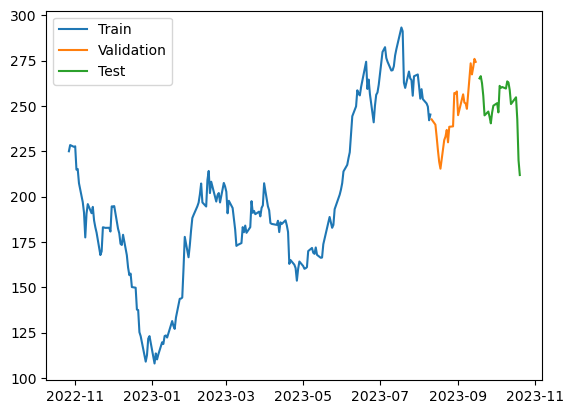

In [102]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 7s 211ms/step - loss: 40218.7734 - mean_absolute_error: 195.6720 - val_loss: 60975.6406 - val_mean_absolute_error: 246.3460
Epoch 2/100
7/7 [==============================] - 0s 17ms/step - loss: 40058.1250 - mean_absolute_error: 195.2650 - val_loss: 60751.7734 - val_mean_absolute_error: 245.8913
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 39877.1836 - mean_absolute_error: 194.7991 - val_loss: 60507.5938 - val_mean_absolute_error: 245.3945
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 39679.7148 - mean_absolute_error: 194.2893 - val_loss: 60238.0664 - val_mean_absolute_error: 244.8445
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 39451.5469 - mean_absolute_error: 193.6974 - val_loss: 59919.5742 - val_mean_absolute_error: 244.1930
Epoch 6/100
7/7 [==============================] - 0s 20ms/step - loss: 39159.6914 - mean_absolute_error: 192.9347 - val_loss: 59

7/7 [==============================] - 1s 3ms/step


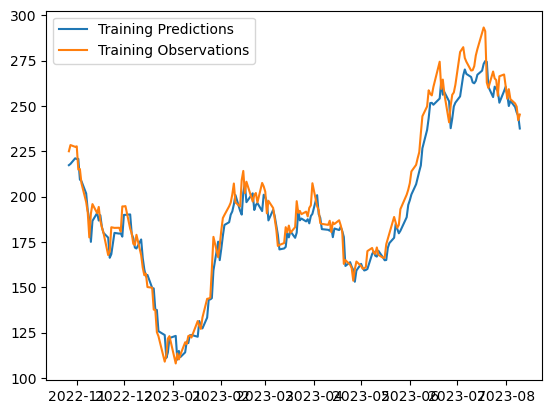

In [104]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 37ms/step


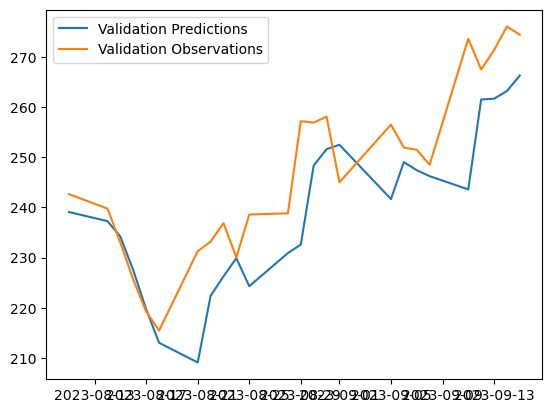

In [105]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 41ms/step


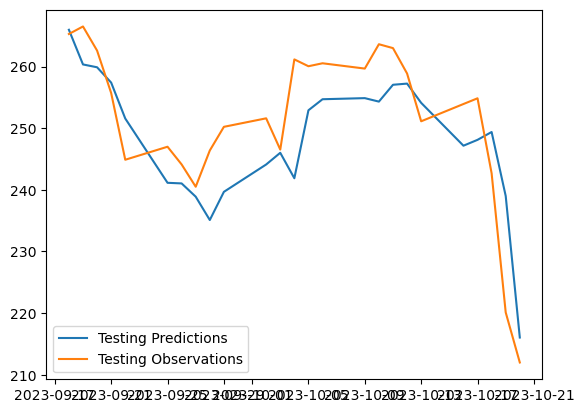

In [106]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

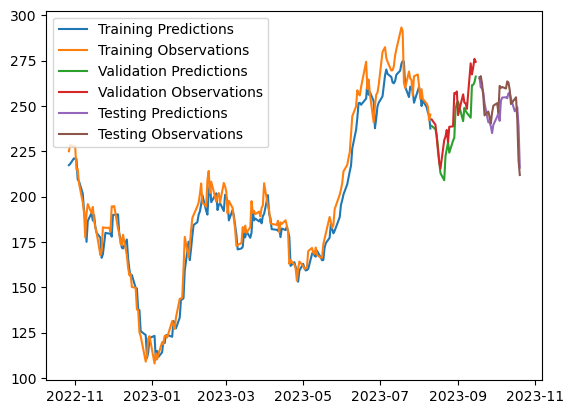

In [107]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [108]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 47ms/step


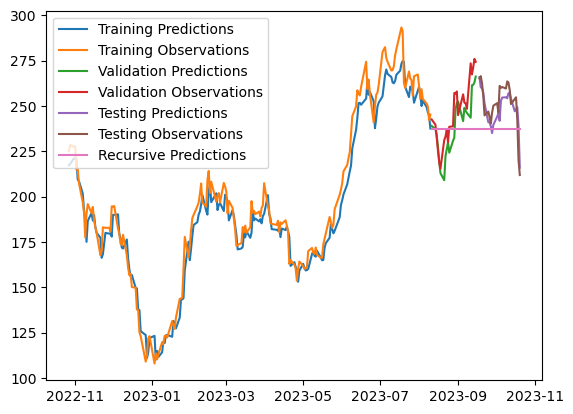

In [109]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])